In [217]:
# -*- coding: utf-8 -*-



#print(__doc__)
from sklearn import preprocessing
from sklearn import linear_model

import numpy as np


class graphicalLasso:
    # X is data (n_samples*n_features)
    # A is precision matrix (n_features*n_features)
    # S is covariance matrix (n_features*n_features)
    # rho is regularizer
    
    # initialization
    def __init__(self, rho=0.1, tol=1e-30):

        self.rho = rho
        self.tol = tol

    # graphical lasso    
    def fit(self,X):
        criterion_dual = []
        criterion_prim = []
        n_samples,n_features = X.shape[0],X.shape[1]

        self.scaler=preprocessing.StandardScaler().fit(X)
        self.X=self.scaler.transform(X)
        
        # self.X = X 
        S = self.X.T.dot(self.X)/n_samples
        
        # initialization of precision matrix;

        
        invA = S + self.rho*np.eye(S.shape[0],S.shape[1])
        A = np.linalg.pinv(invA)
        A_old = A
        
        criterion_prim.append(-np.log(np.linalg.det(A)) + np.trace(np.dot(S,A)) + self.rho*np.sum(np.abs(A)))
        criterion_dual.append(np.log(np.linalg.det(invA)) + n_features)
        
        # graphical lasso can be seperated into many single lasso optimization;
        # the problem can be formulated as: min{log detA -tr SA - rho|A|}

        # block cordinate descent
        while True:
            for j in range(n_features):
                R,s,sjj = self.__get(S,j)
                W = self.__get(invA,j)[0]          
                
                beta_0 = np.zeros(W.shape[1])
                beta = self.coord_lasso_solve(W,s,self.tol,beta_0,self.rho)
                
                w = -W.dot(beta)
                
                invA = self.__put(W,w,sjj+self.rho,j)
                A = np.linalg.pinv(invA)

                criterion_prim.append(-np.log(np.linalg.det(A)) + np.trace(np.dot(S,A)) + self.rho*np.sum(np.abs(A)))
                # criterion_dual.append(np.log(np.linalg.det(S + self.rho*np.sign(A))) + n_features)
                criterion_dual.append(np.log(np.linalg.det(invA)) + n_features)
            
            if np.linalg.norm(A-A_old,ord=2)<self.tol:
                break
            else:
                A_old = A
        
        self.covariance = S
        self.precision = A
        self.primal = criterion_prim
        self.dual = criterion_dual
        return self
         
        
    def soft_threshold(self,b,a):
        if (np.abs(a)<=b):
            return 0
        if(a<-b):
            return a+b
        if(a>b):
            return a-b
        
    def lasso_obj(self,beta,W,s,rho):
        return 0.5*np.dot(beta.T.dot(W),beta) + beta.T.dot(s) + rho*np.sum(np.abs(beta))
        
    def coord_lasso_solve(self,W,s,tol,beta_0,rho):
        n = beta_0.shape[0]
        beta = beta_0.copy()
        obj_0 = self.lasso_obj(beta,W,s,rho)
        while True:
            for i in range(n):
                beta[i] =  self.soft_threshold(rho/W[i,i], beta[i]-(s[i]+np.dot(W[i],beta))/W[i,i])
            obj_1 = self.lasso_obj(beta,W,s,rho)
            if (obj_0-obj_1<tol):
                break
            obj_0 = obj_1    
        return beta
        
            
    # select pth row and column from ndarray X;
    def __get(self,S,idx):
        end = S.shape[0] - 1
        R = S.copy()
        R = np.delete(R,idx,0)
        R = np.delete(R,idx,1)
        s = S[idx].copy()
        s = np.delete(s,idx)
        sii = S[idx][idx]
            
        return [R,s,sii]
    
    # permute the columns and rows : let s to be the first column and row of X;
    def __put(self,R,s,sii,idx):
        # n = R.shape[0] + 1
        X = R.copy()
        X = np.insert(X,idx,s,axis=1)
        s = np.insert(s,idx,sii)
        X = np.insert(X,idx,s,axis=0)        
        return X

In [261]:
X = np.random.rand(10000,100)
#X = np.random.standard_cauchy((10000,25))
g = graphicalLasso(rho=0.02)
R = g.fit(X)

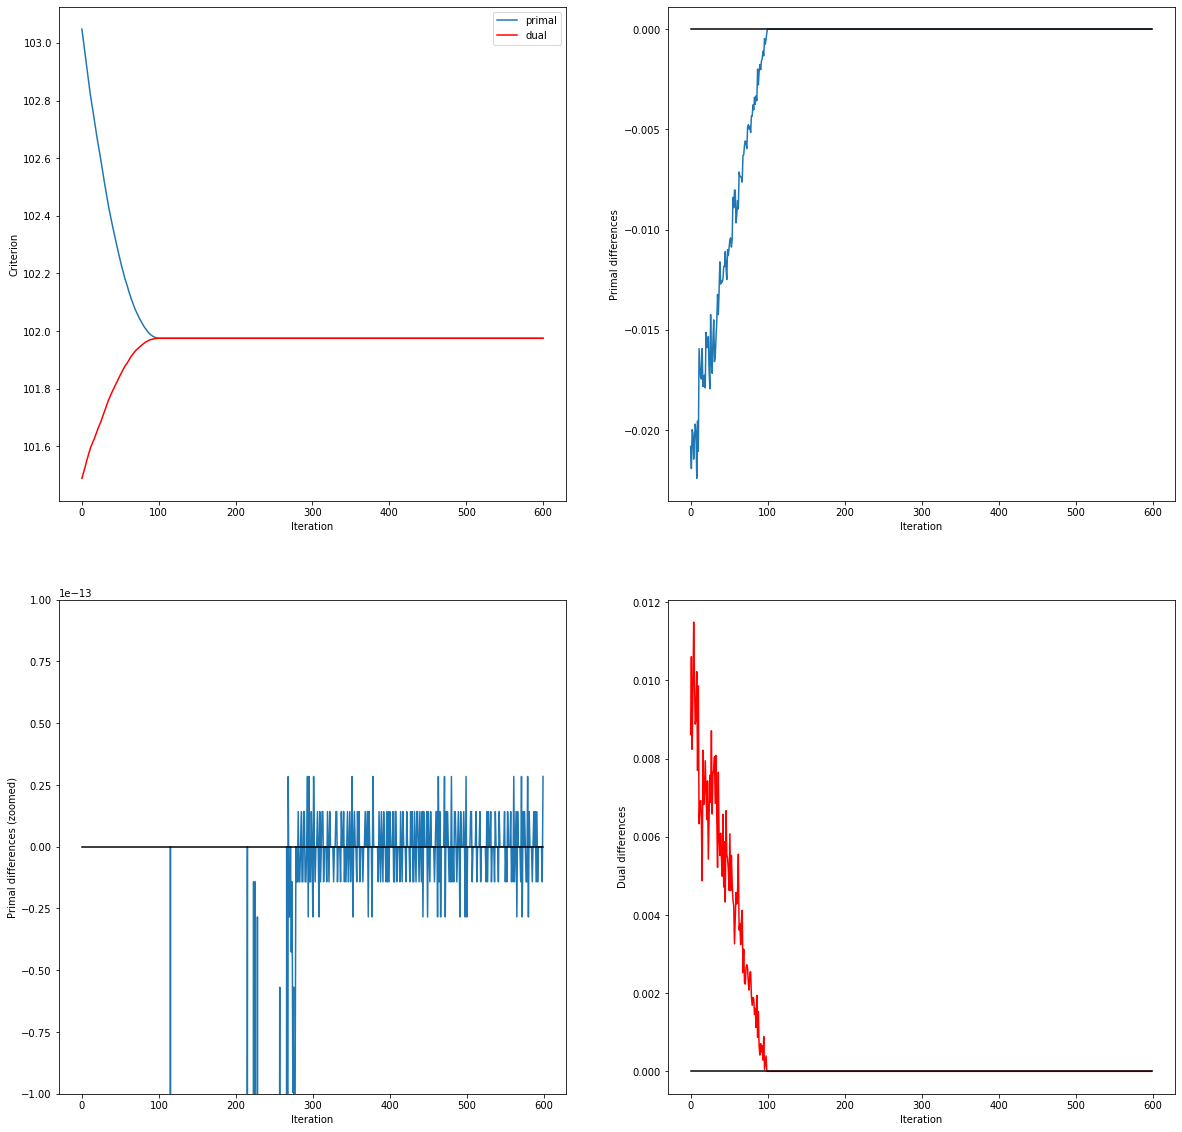

In [262]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
plt.plot(R.primal,label='primal')
plt.plot(R.dual,label='dual',color='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Criterion')

plt.subplot(2,2,2)
plt.plot(np.array(R.primal[1:]) - np.array(R.primal[:-1]))
plt.plot(np.zeros(len(R.primal)-1),color='black')
plt.xlabel('Iteration')
plt.ylabel('Primal differences')

ax1 = plt.subplot(2,2,3)
plt.plot(np.array(R.primal[1:]) - np.array(R.primal[:-1]))
plt.plot(np.zeros(len(R.primal)-1),color='black')
ax1.set_ylim([-1e-13,1e-13])
plt.xlabel('Iteration')
plt.ylabel('Primal differences (zoomed)')

plt.subplot(2,2,4)
plt.plot(np.array(R.dual[1:]) - np.array(R.dual[:-1]),color='red')
plt.plot(np.zeros(len(R.dual)-1),color='black')
plt.xlabel('Iteration')
plt.ylabel('Dual differences')

plt.show()

In [263]:
np.where(np.array(R.primal[1:]) - np.array(R.primal[:-1]) > 0)

(array([268, 281, 285, 288, 289, 293, 295, 298, 301, 306, 309, 312, 313,
        319, 322, 330, 331, 337, 340, 345, 348, 351, 354, 358, 360, 368,
        371, 373, 378, 386, 389, 392, 396, 398, 400, 404, 407, 408, 414,
        417, 422, 427, 429, 432, 435, 436, 439, 442, 444, 448, 450, 453,
        460, 461, 463, 465, 471, 473, 475, 480, 484, 485, 489, 492, 496,
        499, 505, 506, 512, 517, 526, 528, 531, 537, 542, 549, 553, 557,
        561, 564, 566, 571, 573, 575, 579, 581, 587, 589, 591, 599]),)

In [264]:
np.where(np.array(R.dual[1:]) - np.array(R.dual[:-1]) < 0)

(array([], dtype=int64),)

Experiment Setup:


Result: